# Define MHWs using [Hobday definition](https://doi.org/10.1016/j.pocean.2015.12.014)
(>=5 consecutive days w/ a gap of >=3 days in between events for each grid cell)

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import linregress
from xrft import detrend
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import geopandas as gpd
import regionmask
import gsw
import time
from tqdm import tqdm

## OISST

In [7]:
detrended_oi = xr.open_mfdataset('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/detrended_intime_oisstt.nc')
ex_int_oi = xr.open_mfdataset('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/ex_int_oi.nc')
threshold_oi = xr.open_dataset('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/threshold_oi.nc')
event_mask_oi = xr.open_dataset('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/event_mask_oi.nc')

In [ ]:
#--------------------------------------- EVENT COUNTS ------------------------------
#-----------One way to count events----------
#create empty array with correct spatial metadata
#event_count_oi = xr.zeros_like(ex_int_oi.isel({time_dim: 0}), dtype=int)

#fill with number of events per grid cell
#for cell, events in events_by_cell_oi.items():
#    cell_dict = dict(zip(('lat','lon'), cell))
#    event_count_oi.loc[cell_dict] = len(events)

#-----------Use this to count events----------
# create empty array to get spatial and meta data
event_count = xr.zeros_like(ex_int_oi.isel(time=0), dtype=int) #da of 0s
#for key (lat/lon), events (start/stop indices) in da dictionary:
#empty_da.loc[dict((lat, lon))] = len(all events in that grid cell)
for (lat, lon), events in events_by_cell_oi.items(): #items are the lat/lon pairs
    event_count.loc[dict(lat=lat, lon=lon)] = len(events)

#--------------------------------------- TOTAL MHW DAYS ------------------------------
total_mhw_days = event_mask.sum(dim="time")

#--------------------------------------- DURATION ------------------------------
records = []
for (lat, lon), events in events_by_cell.items():
    for i, (start, end) in enumerate(events):
        records.append({"lat": lat, "lon": lon, "event": i, "duration": end - start + 1})

df = pd.DataFrame(records)
duration_da = (df.set_index(["lat", "lon", "event"]).to_xarray())["duration"]

mean_duration = duration_da.mean(dim="event")
median_duration = duration_da.median(dim="event")
max_duration = duration_da.max(dim="event")

#--------------------------------------- MHW Temperatures ------------------------------
mhw_events = detrended_intime.where(event_mask)
mean_mhw_temp = mhw_events.mean(dim="time")

#--------------------------------------- Frequency ------------------------------
years = detrended_intime.time.dt.year.values
nyears = np.unique(years).size #total time period
event_freq = event_count / nyears

#--------------------------------------- Intensity ------------------------------
mhw_intensity = (mhw_events - threshold).mean(dim="time")

## SPEAR-LO

In [91]:
def cartopy_plot(da, cmap_choice, cbar_label, var_title, vmin=None, vmax=None, quiver=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    # ---- infer coord names if not provided ----
    lat_candidates = ['lat', 'latitude', 'yT', 'yh']
    lon_candidates = ['lon', 'longitude', 'xT', 'xh']

    lat_name = next((c for c in lat_candidates if c in da.coords), None)
    lon_name = next((c for c in lon_candidates if c in da.coords), None)

    if lat_name is None or lon_name is None:
        raise ValueError(
            f"Could not infer lat/lon coordinates. "
            f"Found coords: {list(da.coords)}"
        )

    lats = da[lat_name]
    lons = da[lon_name]
    # -------------------------------------------------------------------------------
    
    im = ax.pcolormesh(lons, lats, da, transform=ccrs.PlateCarree(), 
                       vmin=vmin, vmax=vmax, cmap=cmap_choice)
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=8, fontsize=14)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    plt.title(f'{var_title}', fontsize=16, y=1.07)

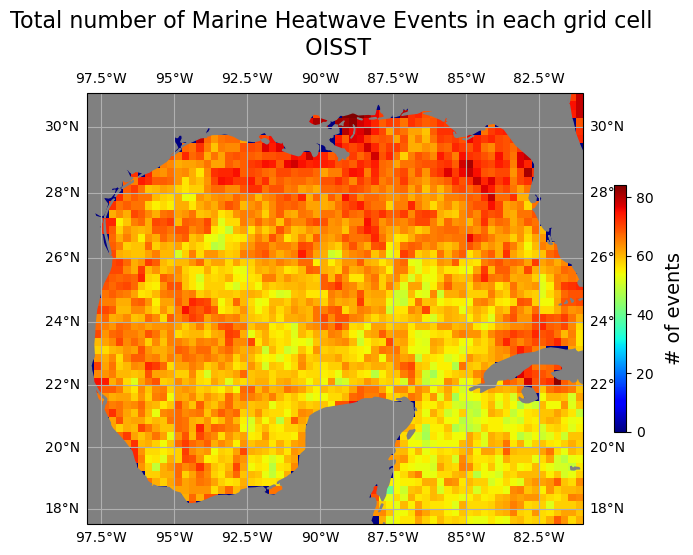

In [ ]:
cartopy_plot(event_count_oi, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n OISST')

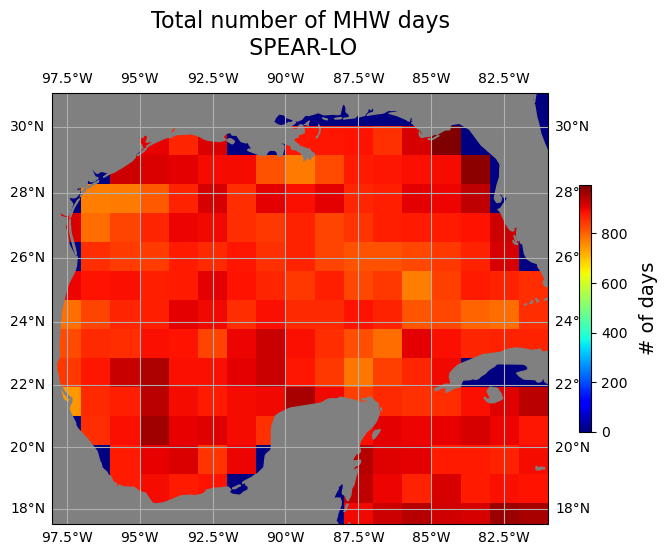

In [26]:
cartopy_plot(total_mhw_days, 'xT', 'yT', 'jet', '# of days', 
             'Total number of MHW days\n SPEAR-LO');#if time res is daily


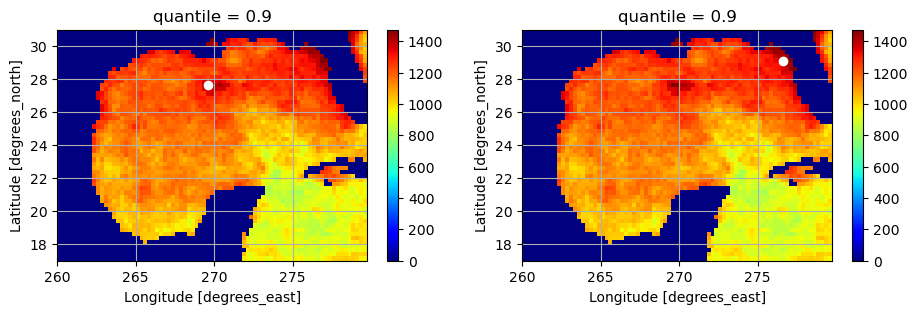

In [53]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
total_mhw_days.plot(cmap='jet', ax=ax0)
ax0.grid()
ax0.plot(269.625, 27.625, 'wo')

total_mhw_days.plot(cmap='jet', ax=ax1)
ax1.grid()
ax1.plot(276.625, 29.125, 'wo');

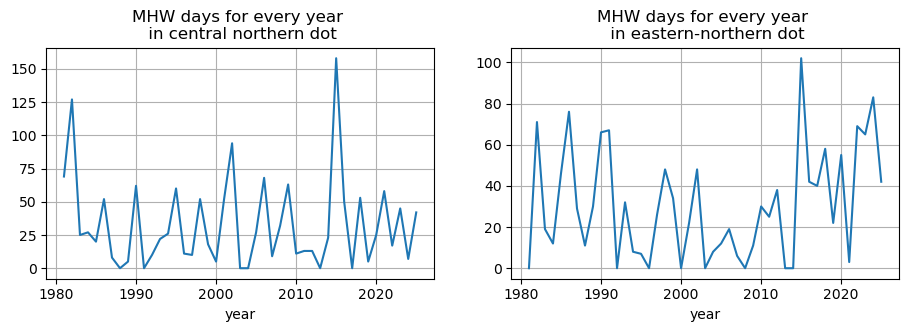

In [55]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
event_mask.sel(lat=27.625, lon=269.625).groupby('time.year').sum('time').plot(ax=ax0)
ax0.grid()
ax0.set_title('MHW days for every year \n in central northern dot')
event_mask.sel(lat=29.125, lon=276.625).groupby('time.year').sum('time').plot(ax=ax1)
ax1.grid()
ax1.set_title('MHW days for every year \n in eastern-northern dot');

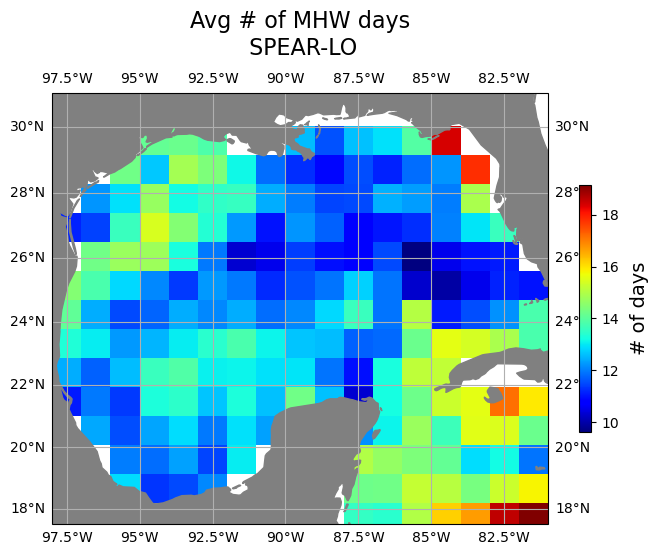

In [33]:
cartopy_plot(mean_duration, 'xT', 'yT', 'jet', '# of days', 
             'Avg # of MHW days\n SPEAR-LO')#,vmin=0, vmax=14,);#if time res is daily


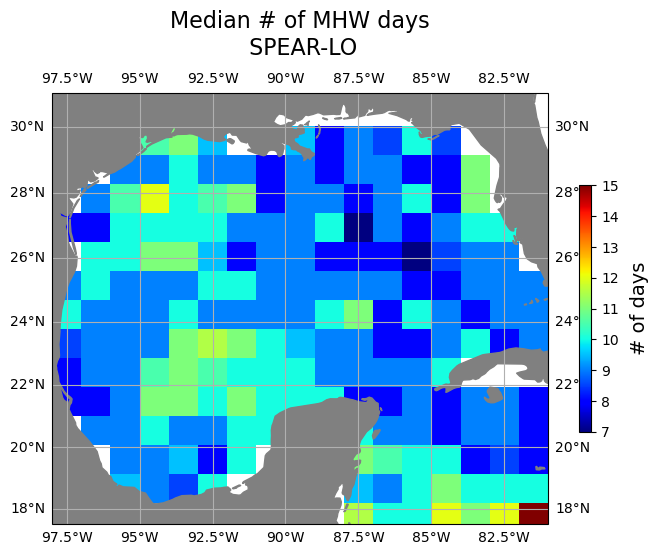

In [34]:
cartopy_plot(median_duration, 'xT', 'yT', 'jet', '# of days', 
             'Median # of MHW days\n SPEAR-LO');#if time res is daily


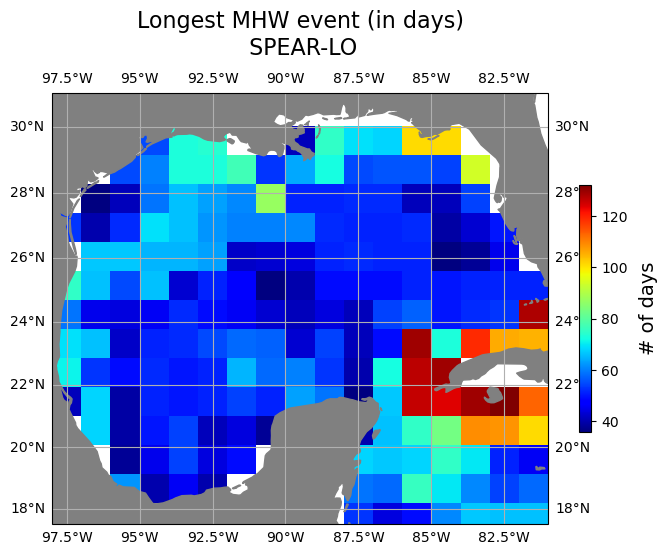

In [35]:
cartopy_plot(max_duration, 'xT', 'yT', 'jet', '# of days', 
             'Longest MHW event (in days)\n SPEAR-LO');#if time res is daily


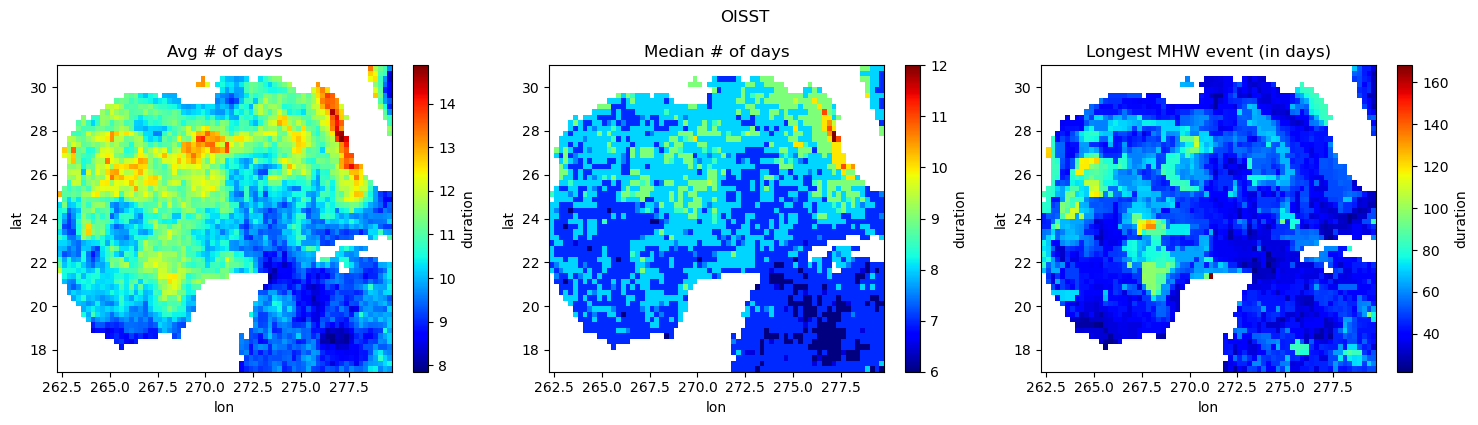

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
mean_duration.plot(ax=ax[0], cmap='jet')
ax[0].set_title('Avg # of days')
median_duration.plot(ax=ax[1], cmap='jet')
ax[1].set_title('Median # of days')
max_duration.plot(ax=ax[2], cmap='jet')
ax[2].set_title('Longest MHW event (in days)')
plt.tight_layout()
plt.suptitle('OISST', y=1.05);

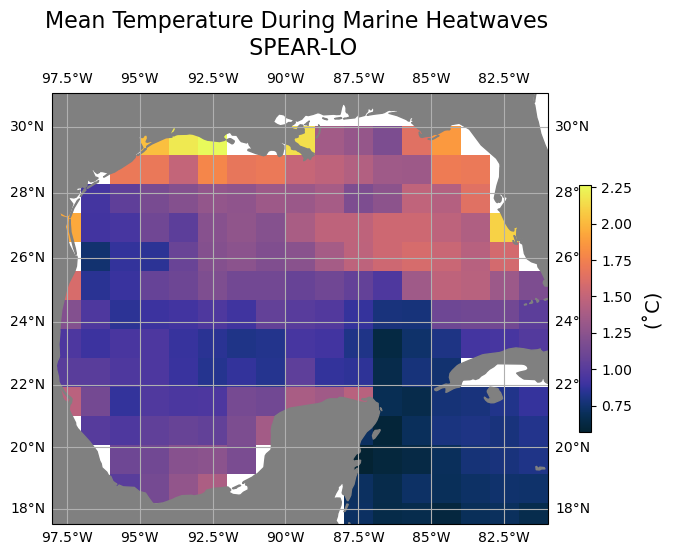

In [36]:
cartopy_plot(mean_mhw_temp, 'xT', 'yT', cmocean.cm.thermal, '(˚C)', 
             'Mean Temperature During Marine Heatwaves \n SPEAR-LO',);

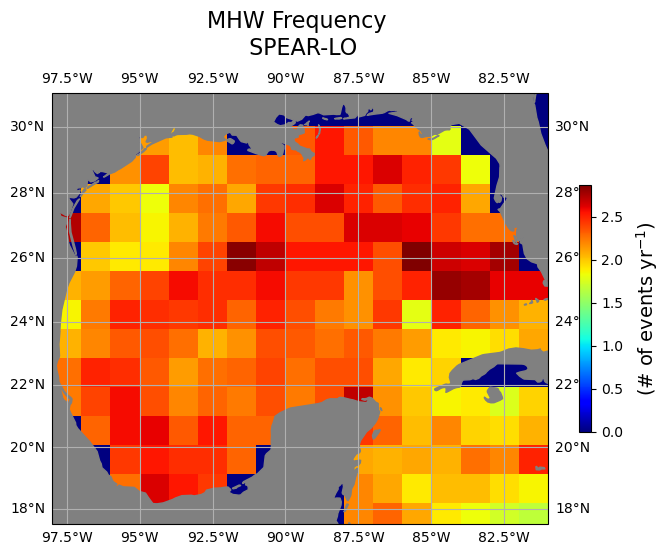

In [37]:
cartopy_plot(event_freq, 'xT', 'yT', 'jet', r'(# of events yr$^{-1}$)', 'MHW Frequency \n SPEAR-LO');

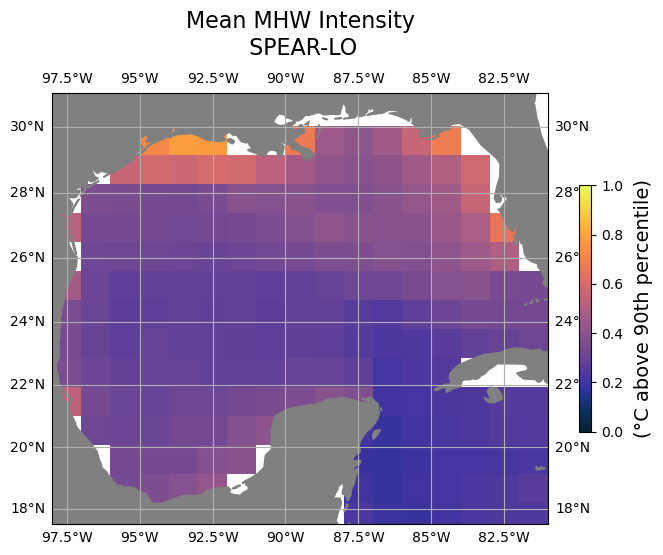

In [38]:
cartopy_plot(mhw_intensity, 'xT', 'yT', cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n SPEAR-LO', vmin=0, vmax=1); 

## BIAS MAPS
(Take difference between `OISST` and `SPEAR-LO`)